# Imports

In [1]:
import os
import pprint
import tempfile
from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd
import sampling

import tensorflow_recommenders as tfrs

import pickle

import datetime

from tensorflow.keras.layers import Flatten   # to flatten the input data
from tensorflow.keras.layers import Dense     # for the hidden layer

# Constants

In [2]:
RATINGS_SMALL = "../Data/EDA_files/ratings_small.parquet"
RECIPES_SMALL = "../Data/EDA_files/recipes_small.parquet"

ING_CLEAN_NO_COMMON = '../Data/cleaned_files/ingredients_clean_without_common_words.obj'
KEYWORDS_CLEAN = '../Data/cleaned_files/keywords_cleaned.obj'
CATEGORIES_CLEAN = '../Data/cleaned_files/categories_cleaned.obj'
NAMES_CLEAN = '../Data/cleaned_files/names_cleaned.obj'



# Load data

In [3]:
recipes_small = pd.read_parquet(RECIPES_SMALL)
ratings_small = pd.read_parquet(RATINGS_SMALL)

with open(ING_CLEAN_NO_COMMON, "rb") as input_file:
    ingredients = pickle.load(input_file)
    
with open(CATEGORIES_CLEAN, "rb") as input_file:
    categories = pickle.load(input_file)
    
with open(NAMES_CLEAN, "rb") as input_file:
    names = pickle.load(input_file)

In [4]:
ratings_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401982 entries, 0 to 1401981
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype              
---  ------         --------------    -----              
 0   RecipeId       1401982 non-null  int32              
 1   AuthorId       1401982 non-null  int32              
 2   Rating         1401982 non-null  int32              
 3   Review         1401982 non-null  object             
 4   DateSubmitted  1401982 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int32(3), object(1)
memory usage: 37.4+ MB


## Ratings

In [5]:
ratings_small["Timestamp"] = ratings_small.DateSubmitted.map(lambda x: int(x.timestamp()))
ratings_small.drop(columns=["Rating", "Review", "DateSubmitted"], inplace=True)

In [6]:
author_min_20 = sampling.get_rating_with_min_number(ratings_small, 20, col_name='AuthorId')
recipe_min_20 = sampling.get_rating_with_min_number(ratings_small, 10, col_name='RecipeId')

ratings_min_20 = author_min_20.merge(recipe_min_20, how='inner')

In [7]:
ratings_sample = ratings_min_20.copy()

In [8]:
ratings_sample.RecipeId

0            780
1           4366
2           4807
3            810
4           5466
           ...  
441660     49088
441661     43023
441662     73866
441663     26370
441664    339905
Name: RecipeId, Length: 441665, dtype: int32

## Recipes

In [9]:
recipes_subset = recipes_small[["RecipeId"]].merge(ingredients, on="RecipeId", how="inner").merge(categories, on="RecipeId",
                                                                                                 how="inner")

In [10]:
recipes_subset["Ingredients"] = recipes_subset["Ingredients"].map(lambda x: " ".join(x))

In [11]:
merged_dataset = ratings_sample.merge(recipes_sample, on="RecipeId", how="inner")

NameError: name 'recipes_sample' is not defined

# Prepare dataset

In [ ]:
merged_dataset.AuthorId = merged_dataset.AuthorId.map(lambda x: bytes(str(x), 'utf-8'))
merged_dataset.RecipeId = merged_dataset.RecipeId.map(lambda x: bytes(str(x), 'utf-8'))

ratings_dict = merged_dataset[['AuthorId', 'RecipeId', 'Timestamp', "Ingredients", "RecipeCategory"]]
ratings_dict = {name: np.array(value) for name, value in ratings_dict.items()}
ratings = tf.data.Dataset.from_tensor_slices(ratings_dict)


ratings = ratings.map(lambda x: {'AuthorId' : x['AuthorId'], 
                                 'RecipeId' : x['RecipeId'],
                                 'Timestamp' : x['Timestamp'],
                                 'Ingredients' : x['Ingredients'], 
                                 'RecipeCategory': x['RecipeCategory']})

In [ ]:
for x in ratings.take(1).as_numpy_iterator():
    pprint.pprint(x)

# Featurization

## Creating dictionaries

In [ ]:
# recipe_ids_lookup = tf.keras.layers.StringLookup()
# recipe_ids_lookup.adapt(ratings.map(lambda x: x["RecipeId"]))

In [ ]:
# print(f"Vocabulary: {recipe_ids_lookup.get_vocabulary()[:3]}")

## Embeddings 

### Recipe id

In [ ]:
# recipe_id_embedding = tf.keras.layers.Embedding(
#                         input_dim=recipe_ids_lookup.vocabulary_size(),
#                         output_dim=32
# )

In [ ]:
# recipe_id_model = tf.keras.Sequential([recipe_ids_lookup, recipe_id_embedding])

### User id

In [ ]:
# user_id_lookup = tf.keras.layers.StringLookup()
# user_id_lookup.adapt(ratings.map(lambda x: x["AuthorId"]))

# user_id_embedding = tf.keras.layers.Embedding(user_id_lookup.vocab_size(), 32)
# user_id_model = tf.keras.Sequential([user_id_lookup, user_id_embedding])

## Normalizing timestamp

In [ ]:
# for x in ratings.take(3).as_numpy_iterator():
#     print(f"Timestamp: {x['Timestamp']}")

In [ ]:
# timestamp_normalization = tf.keras.layers.Normalization(axis=None)

# timestamp_normalization.adapt(ratings.map(lambda x: x['Timestamp']).batch(1024))

# for x in ratings.take(3).as_numpy_iterator():
#     print(f"Normalized timestamp: {timestamp_normalization(x['Timestamp'])}")

## Discretization timestamp

In [ ]:
timestamps = np.concatenate(list(ratings.map(lambda x: x["Timestamp"]).batch(100)))

max_timestamp = timestamps.max()
min_timestamp = timestamps.min()

timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,
)


In [ ]:
# print(f"Buckets: {timestamp_buckets[:3]}")

In [ ]:
# timestamp_embedding_model = tf.keras.Sequential([
#     tf.keras.layers.Discretization(timestamp_buckets.tolist()),
#     tf.keras.layers.Embedding(len(timestamp_buckets)+1, 32)
# ])

# for timestamp in ratings.take(1).map(lambda x: x["Timestamp"]).batch(1).as_numpy_iterator():
#     print(f"Timestamp embedding: {timestamp_embedding_model(timestamp)}")

## Processing text features

In [ ]:
# title_text = tf.keras.layers.TextVectorization()
# title_text.adapt(recipes.map(lambda x: x['Name']).batch(1024))

In [ ]:
# for row in recipes.take(1).map(lambda x: x['Name']).batch(1).as_numpy_iterator():
#     print(title_text(row))

In [ ]:
# title_text.get_vocabulary()[705] + " " + title_text.get_vocabulary()[2] + " " + title_text.get_vocabulary()[60] + " " + title_text.get_vocabulary()[433] + " " + title_text.get_vocabulary()[831]

# Models

In [ ]:
unique_user_ids = np.unique(np.concatenate(list(ratings.batch(1_000).map(lambda x: x["AuthorId"]))))

In [ ]:
unique_recipe_names = np.unique(np.concatenate(list(recipes.batch(1_000).map(lambda x: x["Name"]))))

In [ ]:
unique_recipe_ids = np.unique(np.concatenate(list(recipes.batch(1_000).map(lambda x: x["RecipeId"]))))

## User model

In [ ]:
class UserModel(tfrs.models.Model):
    
    def __init__(self, verbose=False):
        super().__init__()
        self._verbose = verbose
        if(self._verbose):
            print("USER MODEL INIT")
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32)
        ])
        
        self.timestamp_embedding = tf.keras.Sequential([
            tf.keras.layers.Discretization(timestamp_buckets.tolist()),
            tf.keras.layers.Embedding(len(timestamp_buckets)+1, 32),
        ])
        
        self.normalized_timestamp = tf.keras.layers.Normalization(axis=None)
        self.normalized_timestamp.adapt(timestamps)
        
    def call(self, inputs):
        if(self._verbose):
            print("User model call")
            print("INPUTS: ", inputs)
        return tf.concat([
            self.user_embedding(inputs["AuthorId"]),
            self.timestamp_embedding(inputs["Timestamp"]),
            tf.reshape(self.normalized_timestamp(inputs["Timestamp"]), (-1,1)),
        ], axis=1)
        

In [ ]:
user_model = UserModel()

In [ ]:
for row in ratings.batch(1).take(1):
    print(f"Representation: {user_model(row)[0, :3]}")

## Recipe model

In [ ]:
class RecipeModel(tfrs.models.Model):
    
    def __init__(self, verbose=False):
        super().__init__()
        
        max_tokens = 10_000
        self._verbose = verbose
        if(verbose):
            print("RECIPE MODEL INIT")
        self.recipe_id_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_recipe_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_recipe_ids)+1, 32)
        ])
        
        self.name_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens)
        
        self.name_text_embedding = tf.keras.Sequential([
            self.name_vectorizer,
            tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
            tf.keras.layers.GlobalAveragePooling1D()
        ])
        
        self.name_vectorizer.adapt(recipes.map(lambda x: x['Name']))
        
    def call(self, inputs):
        if(self._verbose):
            print("Recipe model call")
            print("INPUTS: ", inputs)
        return tf.concat([
            self.recipe_id_embedding(inputs["RecipeId"]),
            self.name_text_embedding(inputs["Name"])
        ], axis=1)

In [ ]:
recipe_model = RecipeModel()

In [ ]:
# for x in recipes.take(1).as_numpy_iterator():
# #     print(x)
#     print(recipe_model(x))

## Query model

In [ ]:
class QueryModel(tf.keras.Model):
    """Model for encoding user queries."""
    def __init__(self, layer_sizes, verbose=False):
        """Model for encoding user queries.
        Args:
            layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
        """
        
        super().__init__()

        if(verbose):
            print("Query model init")
            
        self._verbose = verbose
        # We first use the user model for generating embeddings.
        self.embedding_model = UserModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
            
    def call(self, inputs):
        if(self._verbose):
            print("Query model call")
            print("Input: ", inputs)
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

## Candidate model

In [ ]:
class CandidateModel(tf.keras.Model):
    """Model for encoding movies."""
    
    def __init__(self, layer_sizes, verbose=False):
        """Model for encoding movies.

        Args:
          layer_sizes:
            A list of integers where the i-th entry represents the number of units
            the i-th layer contains.
        """
        super().__init__()
        if(verbose):
            print("Candidate model init")
        self.embedding_model = RecipeModel()

        # Then construct the layers.
        self.dense_layers = tf.keras.Sequential()

        # Use the ReLU activation for all but the last layer.
        for layer_size in layer_sizes[:-1]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

        # No activation for the last layer.
        for layer_size in layer_sizes[-1:]:
            self.dense_layers.add(tf.keras.layers.Dense(layer_size))
            
        self._verbose = verbose
    
    def call(self, inputs):
        if(self._verbose):
            print("Candidate model call")
            print("Inputs: ", inputs)
        feature_embedding = self.embedding_model(inputs)
        return self.dense_layers(feature_embedding)

## Combined model

In [ ]:
class CombinedModel(tfrs.models.Model):
    
    def __init__(self, layer_sizes, verbose=False):
        super().__init__()
        if(verbose):
            print("Init combined model")
        self.query_model = QueryModel(layer_sizes)
        self.candidate_model = CandidateModel(layer_sizes)
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=recipes.batch(128).map(self.candidate_model),
            ),
        )
        self._verbose = verbose
        
        
    def compute_loss(self, features, training=False):
        if(self._verbose):
            print("Combined model compute loss")
            print("Features: ", features)
        query_embeddings = self.query_model({
            "AuthorId": features["AuthorId"],
            "Timestamp": features["Timestamp"],
        })
        
        recipe_embeddings = self.candidate_model({
            "RecipeId": features["RecipeId"],
            "Name": features["Name"]
        })
        
        return self.task(
            query_embeddings, recipe_embeddings, compute_metrics=not training)

In [ ]:
size = ratings_min_20.shape[0]
train_size = int(0.8 * size)
test_size = size - train_size

tf.random.set_seed(42)
shuffled = ratings_merged.shuffle(size, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(train_size)
test = shuffled.take(train_size).take(test_size)

cached_train = train.shuffle(1_000_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [ ]:
num_epochs = 300

model = CombinedModel([32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))


In [33]:
model.query_model.dense_layers.layers

In [34]:
%%time
one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)



Epoch 1/300
31/31 [==============================] - 56s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 69633.9437 - regularization_loss: 0.0000e+00 - total_loss: 69633.9437
Epoch 2/300
31/31 [==============================] - 51s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 67056.2038 - regularization_loss: 0.0000e+00 - total_loss: 67056.2038
Epoch 3/300
31/31 [==============================] - 53s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - f

31/31 [==============================] - 51s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 52457.2524 - regularization_loss: 0.0000e+00 - total_loss: 52457.2524
Epoch 34/300
31/31 [==============================] - 51s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 52373.2034 - regularization_loss: 0.0000e+00 - total_loss: 52373.2034
Epoch 35/300
31/31 [==============================] - 95s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_

31/31 [==============================] - 92s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 50894.0229 - regularization_loss: 0.0000e+00 - total_loss: 50894.0229 - val_factorized_top_k/top_1_categorical_accuracy: 0.0393 - val_factorized_top_k/top_5_categorical_accuracy: 0.1535 - val_factorized_top_k/top_10_categorical_accuracy: 0.2109 - val_factorized_top_k/top_50_categorical_accuracy: 0.3675 - val_factorized_top_k/top_100_categorical_accuracy: 0.4527 - val_loss: 2189.2954 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2189.2954
Epoch 66/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorize

Epoch 81/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 50512.8297 - regularization_loss: 0.0000e+00 - total_loss: 50512.8297
Epoch 82/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 50492.8315 - regularization_loss: 0.0000e+00 - total_loss: 50492.8315
Epoch 83/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 

31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 50006.3326 - regularization_loss: 0.0000e+00 - total_loss: 50006.3326
Epoch 114/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49993.8818 - regularization_loss: 0.0000e+00 - total_loss: 49993.8818
Epoch 115/300
31/31 [==============================] - 93s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorize

31/31 [==============================] - 93s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49669.1713 - regularization_loss: 0.0000e+00 - total_loss: 49669.1713 - val_factorized_top_k/top_1_categorical_accuracy: 0.0420 - val_factorized_top_k/top_5_categorical_accuracy: 0.1712 - val_factorized_top_k/top_10_categorical_accuracy: 0.2343 - val_factorized_top_k/top_50_categorical_accuracy: 0.3893 - val_factorized_top_k/top_100_categorical_accuracy: 0.4692 - val_loss: 2118.7405 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2118.7405
Epoch 146/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factoriz

Epoch 161/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49536.4009 - regularization_loss: 0.0000e+00 - total_loss: 49536.4009
Epoch 162/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49528.6941 - regularization_loss: 0.0000e+00 - total_loss: 49528.6941
Epoch 163/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+

31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49317.1961 - regularization_loss: 0.0000e+00 - total_loss: 49317.1961
Epoch 194/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49311.1445 - regularization_loss: 0.0000e+00 - total_loss: 49311.1445
Epoch 195/300
31/31 [==============================] - 93s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorize

31/31 [==============================] - 93s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49141.3922 - regularization_loss: 0.0000e+00 - total_loss: 49141.3922 - val_factorized_top_k/top_1_categorical_accuracy: 0.0407 - val_factorized_top_k/top_5_categorical_accuracy: 0.1781 - val_factorized_top_k/top_10_categorical_accuracy: 0.2466 - val_factorized_top_k/top_50_categorical_accuracy: 0.3994 - val_factorized_top_k/top_100_categorical_accuracy: 0.4780 - val_loss: 2088.6604 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2088.6604
Epoch 226/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factoriz

Epoch 241/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49065.2635 - regularization_loss: 0.0000e+00 - total_loss: 49065.2635
Epoch 242/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 49060.7235 - regularization_loss: 0.0000e+00 - total_loss: 49060.7235
Epoch 243/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+

31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 48931.0381 - regularization_loss: 0.0000e+00 - total_loss: 48931.0381
Epoch 274/300
31/31 [==============================] - 50s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 48927.1434 - regularization_loss: 0.0000e+00 - total_loss: 48927.1434
Epoch 275/300
31/31 [==============================] - 93s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorize

In [35]:
accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.48.


In [41]:
one_layer_history.history["total_loss"][-1]

11451.3388671875

In [42]:
model.save_weights('./checkpoints_one_layer/my_checkpoint')

In [37]:
model_two_layer = CombinedM  odel([64, 32])
model_two_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

two_layer_history = model_two_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.35.


In [43]:
model_two_layer.save_weights('./checkpoints_two_layer/my_checkpoint')

In [39]:
two_layer_history.history["total_loss"][-1]

12874.09375

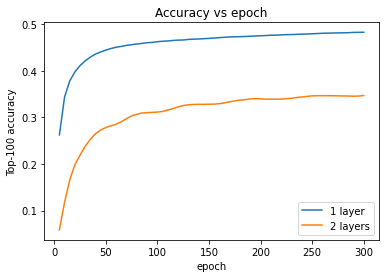

In [45]:
import matplotlib.pyplot as plt

num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [46]:
type(one_layer_history)

keras.callbacks.History

In [51]:
import pickle
with open('../one_layer_history.obj', 'wb') as pickle_file:
    pickle.dump(one_layer_history.history, pickle_file)

In [ ]:
model_three_layer = MovielensModel([128, 64, 32])
model_three_layer.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

three_layer_history = model_three_layer.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

In [52]:
with open('../two_layer_history.obj', 'wb') as pickle_file:
    pickle.dump(two_layer_history.history, pickle_file)

In [54]:
one_layer_history.epoch

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
plt.plot(epochs, one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="1 layer")
plt.plot(epochs, two_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="2 layers")
plt.plot(epochs, three_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="3 layers")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()